In [93]:
import pandas as pd
import numpy as np
from lib import raw_ds_columns, calc_ts_diff
from visualization import display_point_process_events
from scipy.optimize import minimize
from tick.hawkes import HawkesSumExpKern
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from bokeh.io import output_file, show
from bokeh.layouts import gridplot, row, column, grid
from bokeh.plotting import figure
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [185]:
ticks_atm_log_mon = pd.read_csv("data/current.csv", header=None, names=raw_ds_columns())
ticks_atm_log_mon = ticks_atm_log_mon.iloc[1:]

ticks_atm_log_mon["Bid_time"] = ticks_atm_log_mon["Bid_time"].astype(int)
ticks_atm_log_mon["Mid_IV"] = ticks_atm_log_mon["Mid_IV"].astype(float)
ticks_atm_log_mon["Mid_price"] = ticks_atm_log_mon["Mid_price"].astype(float)


time_start = min(ticks_atm_log_mon["Bid_time"])
ticks_atm_log_mon["Bid_time"] = ticks_atm_log_mon["Bid_time"] - time_start
ticks_atm_log_mon = ticks_atm_log_mon.sort_values("Bid_time")

In [208]:
import seaborn as sns

In [210]:
ticks_atm_log_mon

,Trade_date,Bid_time,Option_expiration,Call_Put,Price_strike,Bid_price,Bid_size,Ask_price,Ask_size,Mid_price,Underlying_mid_price,log_moneyness,Time_to_expiry,Mid_IV,Mid_price_diff,Bid_time_diff,Mid_IV_diff
1.0,10/21/2020,0,12/18/2020,C,3435.0,140.7,12,141.7,79,141.20,3440.56,0.0016173231597010362,0.1589041095890411,0.253263,NaN,NaN,NaN
2.0,10/21/2020,0,12/18/2020,C,3435.0,140.7,12,141.7,79,141.20,3440.56,0.0016173231597010362,0.1589041095890411,0.253263,0.00,0.0,0.000000
0.0,10/21/2020,533,12/18/2020,P,3435.0,137.2,12,138.1,108,137.65,3440.56,0.0016173231597010362,0.1589041095890411,0.256945,-3.55,533.0,0.003682
3.0,10/21/2020,4157,12/18/2020,C,3435.0,140.7,12,141.5,34,141.10,3440.56,0.0016173231597010362,0.1589041095890411,0.253080,3.45,3624.0,-0.003865
4.0,10/21/2020,4157,12/18/2020,C,3435.0,140.7,12,141.5,34,141.10,3440.56,0.0016173231597010362,0.1589041095890411,0.253080,0.00,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672.0,10/21/2020,27369169,12/18/2020,C,3500.0,96.5,30,97.3,30,96.90,3444.2650000000003,-0.01605243947771865,0.1589041095890411,0.222399,-40.05,12946.0,-0.014955
1674.0,10/21/2020,27371475,12/18/2020,P,3440.0,137.2,15,138.0,15,137.60,3444.17,0.0012114751698509452,0.1589041095890411,0.255274,40.70,2306.0,0.032876
1675.0,10/21/2020,27371475,12/18/2020,P,3440.0,137.2,15,138.0,15,137.60,3444.17,0.0012114751698509452,0.1589041095890411,0.255274,0.00,0.0,0.000000
1673.0,10/21/2020,27371476,12/18/2020,C,3440.0,130.6,15,131.5,20,131.05,3444.2200000000003,0.001225992350208193,0.1589041095890411,0.235618,-6.55,1.0,-0.019657


In [187]:
tick_diff_atm = calc_ts_diff(ticks_atm_log_mon, keys=['Mid_price', 'Bid_time', 'Mid_IV'])
tick_diff_atm["Mid_price_ret"] = np.log1p(ticks_atm_log_mon["Mid_price"].pct_change())
tick_diff_atm["Mid_IV_diff_sign"] = np.sign(tick_diff_atm["Mid_IV_diff"])



tick_diff_atm.head(1)

<ipython-input-187-b8d3239921e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tick_diff_atm["Mid_price_ret"] = np.log1p(ticks_atm_log_mon["Mid_price"].pct_change())
<ipython-input-187-b8d3239921e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tick_diff_atm["Mid_IV_diff_sign"] = np.sign(tick_diff_atm["Mid_IV_diff"])


,Trade_date,Bid_time,Option_expiration,Call_Put,Price_strike,Bid_price,Bid_size,Ask_price,Ask_size,Mid_price,Underlying_mid_price,log_moneyness,Time_to_expiry,Mid_IV,Mid_price_diff,Bid_time_diff,Mid_IV_diff,Mid_price_ret,Mid_IV_diff_sign
2.0,10/21/2020,0,12/18/2020,C,3435.0,140.7,12,141.7,79,141.2,3440.56,0.0016173231597010362,0.1589041095890411,0.253263,0.0,0.0,0.0,0.0,0.0


In [6]:

def distr_hist(data, bins=200):
    hist, edges = np.histogram(data, density=True, bins=bins)
    p = figure(title=data.name)
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="white")
    return p

def count_hist(data, bins):
    p = figure(title="Bid_time", x_axis_label='Bid Time')
    edges = np.linspace(min(data["Bid_time"]), max(data["Bid_time"]), bins)
    hist_plus, hist_minus = [], []
    for i in range(1, len(edges)):
        l, r = edges[i - 1], edges[i]
        bucket_ = data[(data["Bid_time"] >= l) & (data["Bid_time"] <= r)]
        hist_plus.append(len(bucket_[bucket_["Mid_IV_diff_sign"] > 0]))
        hist_minus.append(len(bucket_[bucket_["Mid_IV_diff_sign"] < 0]))
    p.quad(top=hist_plus, bottom=0, left=edges[:-1], right=edges[1:], line_color="white", fill_color="green", fill_alpha=0.6, legend_label="Up tick")
    p.quad(top=hist_minus, bottom=0, left=edges[:-1], right=edges[1:], line_color="white", fill_color="red", fill_alpha=0.6, legend_label="Down tick")
    return p

def mean_hist(data, mean_col, bins):
    p = figure(title=mean_col, x_axis_label='Bid Time')
    edges = np.linspace(min(data["Bid_time"]), max(data["Bid_time"]), bins)
    hist = []
    for i in range(1, len(edges)):
        l, r = edges[i - 1], edges[i]
        hist.append(np.mean(data[(data["Bid_time"] >= l) & (data["Bid_time"] <= r)][mean_col]))
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="white", legend_label="{} mean value".format(mean_col))
    return p

def show_ts_df(ts_df):
    p2 = count_hist(ts_df, bins=100)

    p3_a = mean_hist(ts_df, "Mid_price", bins=300)
    p3_b = distr_hist(ts_df["Mid_price_ret"], bins=300)
    
    p4_a = mean_hist(ts_df, "Mid_IV", bins=300)
    p4_b = distr_hist(ts_df["Mid_IV_diff"])
    grid_ = grid(column(row(p2, sizing_mode='stretch_width'), row(p3_a, p3_b, sizing_mode='stretch_width'), row(p4_a, p4_b, sizing_mode='stretch_width')))

    show(grid_)

show_ts_df(tick_diff_atm)

In [7]:
def quantile_analysis(data, columns):
    rows = []
    for col in columns:
        duration_Q99 = np.quantile(data[col], 0.99)
        duration_Q95 = np.quantile(data[col], 0.95)
        duration_Q90 = np.quantile(data[col], 0.90)
        duration_MAX = max(data[col])
        duration_N = len(data[col])
        duration_N_gt_2_Q99 = len(data[col][data[col] > 2*duration_Q99])
        duration_N_gt_Q99 = len(data[col][data[col] > duration_Q99])
        duration_frac = "{:.2f}%".format((duration_N_gt_2_Q99 / duration_N) * 100)
        rows.append([col, duration_Q90, duration_Q95, duration_Q99, duration_MAX, duration_N, duration_N_gt_Q99, duration_N_gt_2_Q99, duration_frac])
    return pd.DataFrame(
        rows, 
        columns=["Name", "Q90", "Q95", "Q99", "Max", "N", "N>Q99", "N>2*Q99", "Fraction"]
    )


In [8]:
quantile_analysis(tick_diff_atm, ["Bid_time_diff", "Mid_price_ret", "Mid_IV_diff"])

,Name,Q90,Q95,Q99,Max,N,N>Q99,N>2*Q99,Fraction
0,Bid_time_diff,44889.500000,84473.000000,216254.500000,3.105038e+06,1676,17,2,0.12%
1,Mid_price_ret,0.077256,0.201977,0.379158,5.557933e-01,1676,17,0,0.00%
2,Mid_IV_diff,0.015207,0.016692,0.030651,4.570552e-02,1676,17,0,0.00%


In [9]:
def filter_gt_Q99(df, columns):
    for col in columns:
        df = df.loc[~(df[col] > np.quantile(df[col], 0.99))]
    return df

def filter_zeros(df, columns):
    for col in columns:
        df = df[df[col] != 0.0]
    return df

def remove_n_first(df, n):
    return df.iloc[n:]

def remove_outliers(data, columns):
    df = data.copy()
    df = filter_gt_Q99(df, columns)
    df = filter_zeros(df, columns)
#     one of the datasets has a supermassive black hole between the ticks
    df = remove_n_first(df, 5)
    return df
        

In [10]:
filtered_df = remove_outliers(tick_diff_atm, ["Bid_time_diff", "Mid_price_ret", "Mid_IV_diff"])
filtered_df

,Trade_date,Bid_time,Option_expiration,Call_Put,Price_strike,Bid_price,Bid_size,Ask_price,Ask_size,Mid_price,Underlying_mid_price,log_moneyness,Time_to_expiry,Mid_IV,Mid_price_diff,Bid_time_diff,Mid_IV_diff,Mid_price_ret,Mid_IV_diff_sign
10.0,10/21/2020,3131954,12/18/2020,C,3500.0,99.4,238,100.0,44,99.70,3441.73,-0.016788716548648823,0.1589041095890411,0.229643,-23.15,17976.0,-0.041286,-0.208798,-1.0
11.0,10/21/2020,3131987,12/18/2020,C,3500.0,99.4,238,100.4,30,99.90,3441.9,-0.016739324004297996,0.1589041095890411,0.229872,0.20,33.0,0.000229,0.002004,1.0
12.0,10/21/2020,3146613,12/18/2020,C,3500.0,100.3,147,101.5,34,100.90,3444.1850000000004,-0.01607566676397418,0.1589041095890411,0.229832,1.00,14626.0,-0.000039,0.009960,-1.0
23.0,10/21/2020,3382080,12/18/2020,P,3435.0,137.3,15,138.2,15,137.75,3445.5550000000003,0.003068068863502391,0.1589041095890411,0.261431,-1.00,1.0,0.017495,-0.007233,1.0
24.0,10/21/2020,3382754,12/18/2020,P,3435.0,137.2,90,138.2,60,137.70,3445.25,0.0029795450988045684,0.1589041095890411,0.261078,-0.05,674.0,-0.000353,-0.000363,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1666.0,10/21/2020,27323443,12/18/2020,C,3500.0,96.3,30,97.2,30,96.75,3444.38,-0.01601905119888867,0.1589041095890411,0.222028,-17.55,87095.0,-0.048417,-0.166696,-1.0
1670.0,10/21/2020,27355691,12/18/2020,C,3430.0,136.3,15,137.5,45,136.90,3444.25,0.004145912764722784,0.1589041095890411,0.237281,3.15,35.0,-0.020350,0.023278,-1.0
1671.0,10/21/2020,27356223,12/18/2020,C,3430.0,136.4,15,137.5,15,136.95,3444.2700000000004,0.004151719527278634,0.1589041095890411,0.237353,0.05,532.0,0.000072,0.000365,1.0
1672.0,10/21/2020,27369169,12/18/2020,C,3500.0,96.5,30,97.3,30,96.90,3444.2650000000003,-0.01605243947771865,0.1589041095890411,0.222399,-40.05,12946.0,-0.014955,-0.345936,-1.0


In [11]:
quantile_analysis(filtered_df, ["Bid_time_diff", "Mid_price_ret", "Mid_IV_diff"])

,Name,Q90,Q95,Q99,Max,N,N>Q99,N>2*Q99,Fraction
0,Bid_time_diff,67009.000000,111913.000000,179784.000000,215517.000000,801,8,0,0.00%
1,Mid_price_ret,0.138629,0.244849,0.341536,0.363625,801,8,0,0.00%
2,Mid_IV_diff,0.015629,0.017307,0.026428,0.027837,801,8,0,0.00%


In [12]:
show_ts_df(filtered_df)

In [13]:
n_plus_ts, n_minus_ts = filtered_df.loc[filtered_df["Mid_IV_diff_sign"] > 0], \
                        filtered_df.loc[filtered_df["Mid_IV_diff_sign"] < 0]

In [16]:
n_minus_ts

,Trade_date,Bid_time,Option_expiration,Call_Put,Price_strike,Bid_price,Bid_size,Ask_price,Ask_size,Mid_price,Underlying_mid_price,log_moneyness,Time_to_expiry,Mid_IV,Mid_price_diff,Bid_time_diff,Mid_IV_diff,Mid_price_ret,Mid_IV_diff_sign
10.0,10/21/2020,3131954,12/18/2020,C,3500.0,99.4,238,100.0,44,99.70,3441.73,-0.016788716548648823,0.1589041095890411,0.229643,-23.15,17976.0,-0.041286,-0.208798,-1.0
12.0,10/21/2020,3146613,12/18/2020,C,3500.0,100.3,147,101.5,34,100.90,3444.1850000000004,-0.01607566676397418,0.1589041095890411,0.229832,1.00,14626.0,-0.000039,0.009960,-1.0
24.0,10/21/2020,3382754,12/18/2020,P,3435.0,137.2,90,138.2,60,137.70,3445.25,0.0029795450988045684,0.1589041095890411,0.261078,-0.05,674.0,-0.000353,-0.000363,-1.0
25.0,10/21/2020,3407730,12/18/2020,C,3445.0,132.7,60,133.5,14,133.10,3445.575,0.00016689463545035881,0.1589041095890411,0.242496,-4.60,24976.0,-0.018582,-0.033977,-1.0
32.0,10/21/2020,3507158,12/18/2020,P,3435.0,136.9,75,137.8,60,137.35,3445.8999999999996,0.0031681928577205975,0.1589041095890411,0.260994,-0.45,34440.0,-0.000053,-0.003271,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1659.0,10/21/2020,27191282,12/18/2020,C,3440.0,131.3,30,132.2,70,131.75,3445.025,0.00145968994803308,0.1589041095890411,0.236126,-5.00,539.0,-0.018336,-0.037248,-1.0
1666.0,10/21/2020,27323443,12/18/2020,C,3500.0,96.3,30,97.2,30,96.75,3444.38,-0.01601905119888867,0.1589041095890411,0.222028,-17.55,87095.0,-0.048417,-0.166696,-1.0
1670.0,10/21/2020,27355691,12/18/2020,C,3430.0,136.3,15,137.5,45,136.90,3444.25,0.004145912764722784,0.1589041095890411,0.237281,3.15,35.0,-0.020350,0.023278,-1.0
1672.0,10/21/2020,27369169,12/18/2020,C,3500.0,96.5,30,97.3,30,96.90,3444.2650000000003,-0.01605243947771865,0.1589041095890411,0.222399,-40.05,12946.0,-0.014955,-0.345936,-1.0


In [17]:
display_point_process_events(n_plus_ts)

In [17]:
def get_learner(decays, verbose=False):
    return HawkesSumExpKern(decays, verbose=verbose, tol=1e-10, max_iter=1000)


def get_HP_exp_learner(decays, events, verbose=False):
    learner = get_learner(decays, verbose)
    learner.fit(events)
    if verbose:
        print("Adj: {}, decays: {}, baselines: {}".format(learner.adjacency, decays, learner.baseline))
    return learner


def fun(decays, events):
    return - HawkesSumExpKern(decays=decays, penalty="elasticnet", elastic_net_ratio=0.9, solver="agd", max_iter=1000).fit(events).score()


In [24]:
decays_ = [0.001, 0.01, 0.5]
events_ = np.array(list(n_plus_ts["Bid_time"].astype(float)))
decays_hat = minimize(fun, x0=[decays_], method="Nelder-Mead", args=[events_], tol=1e-05).x
learner = get_HP_exp_learner(decays_hat, [events_])

In [18]:
learner.adjacency

NameError: name 'learner' is not defined

## Outliers removal

In [188]:
def delta_trimmed_sample_stats(data, delta):
    sample_mean = np.mean(data[data<np.quantile(data,1-delta)])
    sample_std = np.std(data[data<np.quantile(data,1-delta)])
    return sample_mean, sample_std

def is_outlier(value, mean, std, gamma):
    if abs(value-mean)<3*std+gamma:
        return True
    return False

def assign(data_slice, value, delta, gamma):
        mean, std = delta_trimmed_sample_stats(data_slice, delta)
        return is_outlier(value, mean,std, gamma)


def remove_outliers(data, delta, k, gamma):
    """
    Delta is the percantage of trimming to calculate adjusted sample statistics.
    Delta should be determined  on the basis of frequesncy of outliers,
    the higher the frequency the larger is delta. Delta should be between 0 and 1.
    
    k gives a radius of neighbourhood obervations.
    Should be chosen on the basis of trading intensity. Less trading activity corresponds to smaller k.
    
    Gamma is a granularity parameter. It's role is to avoid zero std produced by a sequence of k equal prices.
    Gamma should be a multiple of the minimum price variation allowed.
    """
    n=len(data)
    non_outliers_series=pd.Series([0]*n)
    
    for i in range(n):
        if i<k//2:
            non_outliers_series[i] = assign(data.iloc[:k], data.iloc[i], delta, gamma)
        elif n-i<k//2:
            non_outliers_series[i] = assign(data.iloc[n-k:], data.iloc[i], delta, gamma)
        else:
            non_outliers_series[i] = assign(data.iloc[k//2:k+k//2], data.iloc[i], delta, gamma)
    return non_outliers_series

In [189]:
non_out=remove_outliers(tick_diff_atm['Mid_price'], delta=0.01, k=80, gamma=0.2)

In [191]:
tick_diff_atm.reset_index(drop=True, inplace=True)

In [192]:
tick_diff_atm_post=tick_diff_atm[non_out]

In [193]:
tick_diff_atm_post['Mid_price_diff']=tick_diff_atm_post['Mid_price'].diff()

<ipython-input-193-9e0542d3e71b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tick_diff_atm_post['Mid_price_diff']=tick_diff_atm_post['Mid_price'].diff()


## Post-filtering analysis

1) Plot of mid-price changes
2) Plot intra-day seasonality - autoregressive conditional durations (can look up if necessary)
3) ACF

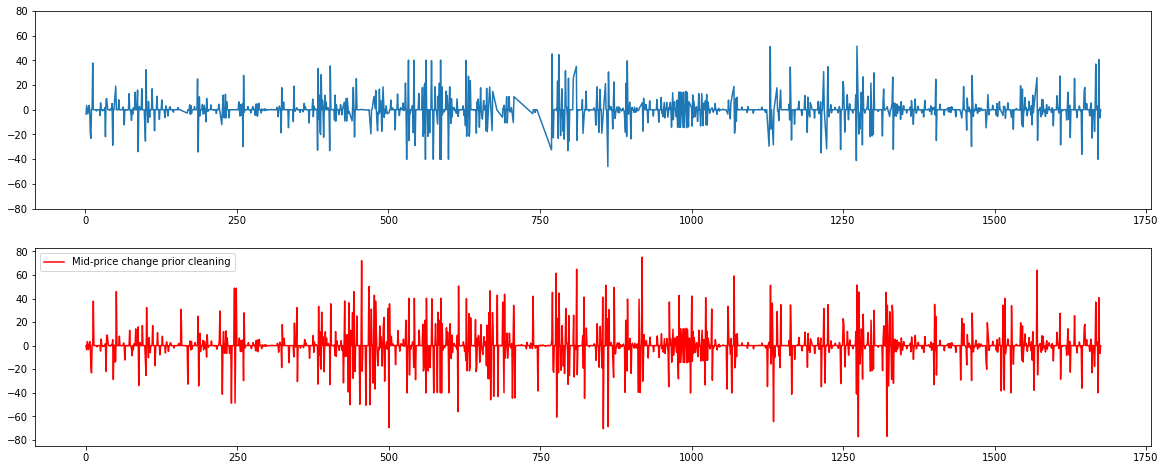

In [194]:
# mid-price changes
fig, ax = plt.subplots(2,1, figsize=(20,8))
ax[0].plot(tick_diff_atm_post['Mid_price_diff'], label='Mid-price change post cleaning')
ax[1].plot(tick_diff_atm['Mid_price_diff'],label='Mid-price change prior to cleaning', color ='r')
ax[0].set_ylim((-80,80))
plt.legend()

In [195]:
time_start = min(tick_diff_atm_post["Bid_time"])
tick_diff_atm_post["Bid_time"] = tick_diff_atm_post["Bid_time"] - time_start
tick_diff_atm_post = tick_diff_atm_post.sort_values("Bid_time")

tick_diff_atm_post = calc_ts_diff(tick_diff_atm_post, keys=['Mid_price', 'Bid_time', 'Mid_IV'])
tick_diff_atm_post["Mid_price_ret"] = np.log1p(tick_diff_atm_post["Mid_price"].pct_change())
tick_diff_atm_post["Mid_IV_diff_sign"] = np.sign(tick_diff_atm_post["Mid_IV_diff"])


<ipython-input-195-66795dda7a2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tick_diff_atm_post["Bid_time"] = tick_diff_atm_post["Bid_time"] - time_start


In [196]:
tick_diff_atm_post['Duration']=tick_diff_atm_post['Bid_time'].diff()
tick_diff_atm['Duration']=tick_diff_atm['Bid_time'].diff()

<ipython-input-196-07098e96985d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tick_diff_atm['Duration']=tick_diff_atm['Bid_time'].diff()


In [202]:
def autocorrelation(series, lag_list):
    autocorr_list=[]
    for lag in lag_list:
        autocorr_list.append(series.autocorr(lag=lag))
    result=pd.DataFrame(data=autocorr_list, index=lag_list)
    return result.T

In [203]:
autocorrelation(tick_diff_atm_post['Duration'], [1,2,3,4,5])


,1,2,3,4,5
0,-0.01,0.015103,-0.004598,0.053153,-0.004418


In [204]:
autocorrelation(tick_diff_atm['Duration'], [1,2,3,4,5])

,1,2,3,4,5
0,-0.001292,0.002754,0.001768,0.057789,-0.001769
